# **EY Data Challenge Sentinel-2 Notebook**

Some changes from the sample notebook:
1. Select 'low cloud' scenes with overall cloud_cover less than 20%
   - Note that this removes the scene from 24-7-2021
   - Sample Notebook is 30%<br>
2. The output GeoTiff is the median composite image.
   - Sample Notebook outputs the image from 24-7-2021 <br>
3. The output GeoTiff contains all the available bands
   - To be experimented with the model
   - Sample Notebook only outputs B01, B04, B06, B08

**Install and Import Packages**

In [131]:
pip install rioxarray stackstac pystac_client planetary_computer odc.stac osmnx

Note: you may need to restart the kernel to use updated packages.


In [132]:
# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

**Discover and load the data for analysis**

In [133]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [134]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [135]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <20%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [136]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 20}},
)

In [137]:
items = list(search.items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 7


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. 

In [138]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [139]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [140]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [141]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 373MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 7)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 34MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. You may want to use a scene from a single date, or create a median mosaic using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above. 

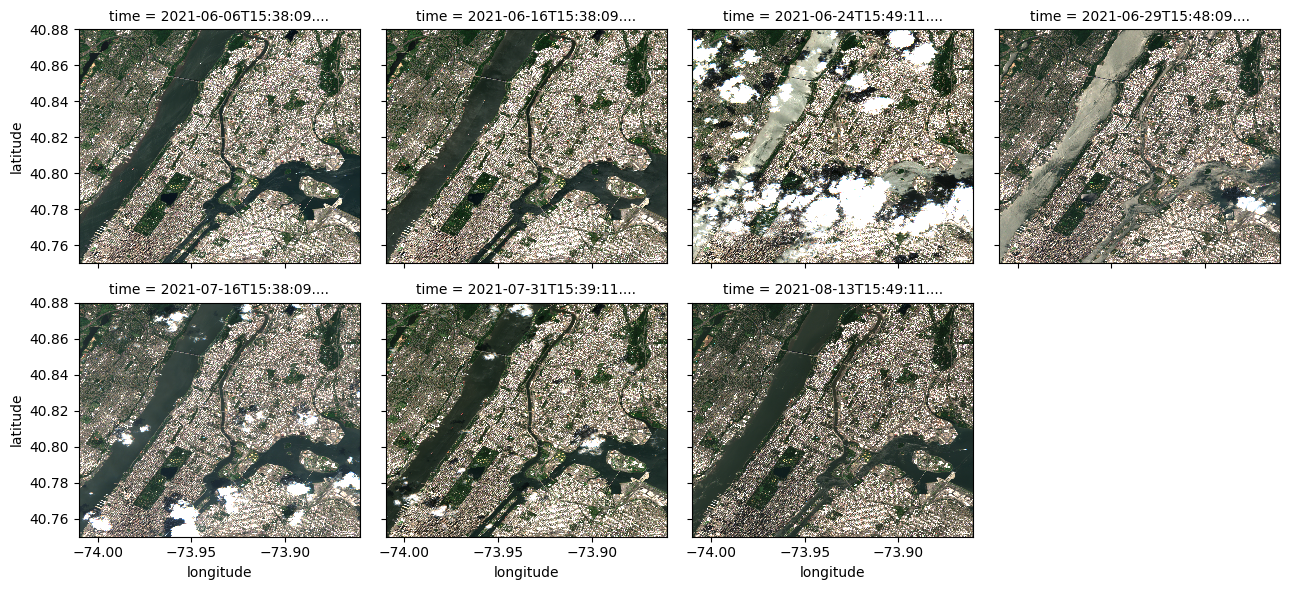

In [142]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<20% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. 

In [143]:
median = data.median(dim="time").compute()

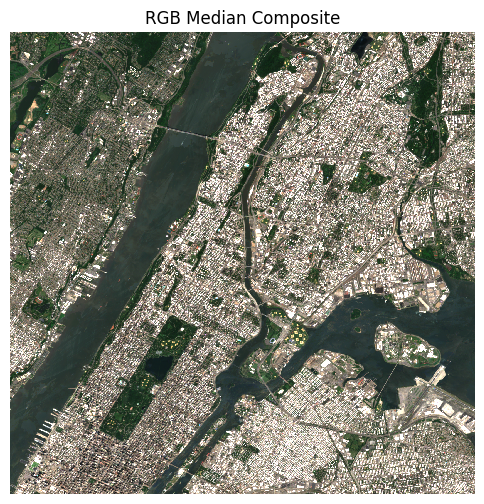

In [144]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [145]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

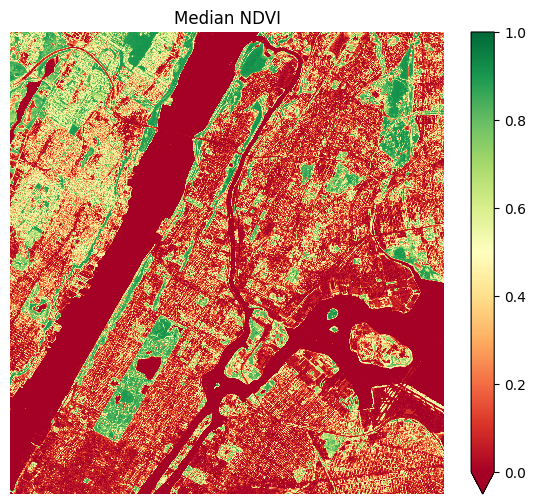

In [146]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [147]:
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

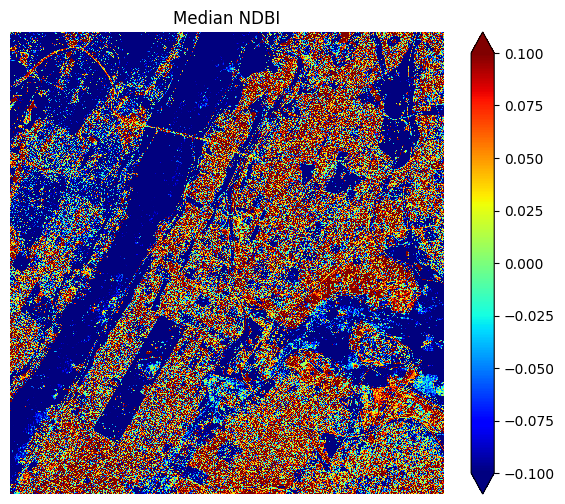

In [148]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [149]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

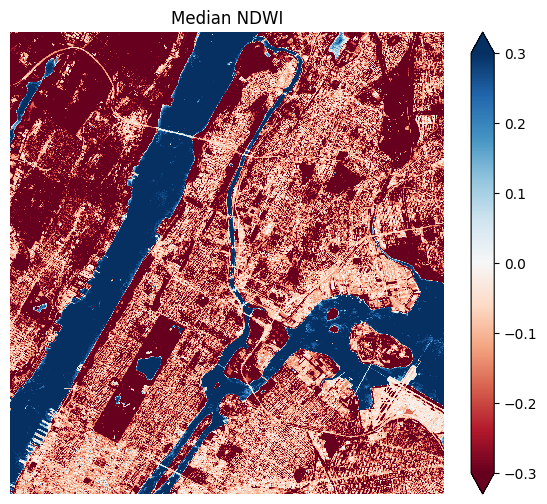

In [150]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [151]:
filename = "S2.tiff"

In [152]:
# Calculate the dimensions of the file
height = median.dims["latitude"]
width = median.dims["longitude"]

In [153]:
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)

In [154]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3)
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7)
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B11,10)
    dst.write(median.B12,11)
    dst.close()

In [155]:
# Show the location and size of the new output file
!ls *.tiff

S2.tiff
